Some info about this notebook:
- Currently using resnet20 or resnet32 for cifar10, if you want to use other network, feel free to change it in the `train` function as that's where downloading the dataset is
- `depth` hyperparam in `general_hyperparameters` will allow toggle between resnet20 or 32
- Currently using `MultiStepLR` as learning rate scheduler
- Feel free to go through the `train` function as change as you see fit to add Apollo in!

In [1]:
from __future__ import print_function
import logging
import os
import sys
# sys.path.append("C:\\Users\\Tuan Tran\\Desktop\\CS595_final\\adahessian\\image_classification")

import numpy as np
import argparse
from tqdm import tqdm, tqdm_notebook, trange

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable

from optim.adahessian_helpers.utils import *
from optim.adahessian_helpers.models.resnet import *
from optim.adahessian_helpers.optim_adahessian import Adahessian
from optim import Apollo
import matplotlib.pyplot as plt
import time

In [2]:
"""
Function to initialize optimizers, download data, lr scheduler then training loop and checkpoint best model
"""
def train(dataset_name,
          optimizer_str,
          lr,
          lr_decay,
          lr_decay_epoch,
          weight_decay,
          batch_size,
          test_batch_size,
          epochs,
          depth,
          seed):

    # set random seed to reproduce the work
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Create dir for checkpoint best model per optimizer
    if not os.path.isdir('checkpoint/'):
        os.makedirs('checkpoint/')
    
    print(f"Retrieving {dataset_name}")
    # get dataset
    train_loader, test_loader = getData(
        name=dataset_name, train_bs=batch_size, test_bs=test_batch_size)

    # make sure to use cudnn.benchmark for second backprop
    cudnn.benchmark = True

    # get model and optimizer
    model = resnet(num_classes=10, depth=depth).cuda()
    model = torch.nn.DataParallel(model)
    #print('    Total params: %.2fM' % (sum(p.numel()
    #                                       for p in model.parameters()) / 1000000.0))

    criterion = nn.CrossEntropyLoss()
    if optimizer_str == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay)
    elif optimizer_str == 'adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == 'adamw':
        print('For AdamW, we automatically correct the weight decay term for you! If this is not what you want, please modify the code!')
        weight_decay = weight_decay / lr
        optimizer = optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == 'adahessian':
        print('For AdaHessian, we use the decoupled weight decay as AdamW. Here we automatically correct this for you! If this is not what you want, please modify the code!')
        weight_decay = weight_decay / lr
        optimizer = Adahessian(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay)
    elif optimizer_str == "apollo":
        weight_decay = weight_decay / lr 
        optimizer = Apollo(
            model.parameters(),
            lr = lr,
            weight_decay = weight_decay,
            init_lr = lr / 5)
    else:
        raise Exception('We do not support this optimizer yet!!')

    # learning rate schedule
    scheduler = lr_scheduler.MultiStepLR(
        optimizer,
        lr_decay_epoch,
        gamma=lr_decay,
        last_epoch=-1)

    # Start training loop
    best_acc = 0.0
    losses_list = []
    acc_list = []
    
    for epoch in range(1, epochs + 1):
        print('Current Epoch: ', epoch)
        train_loss = 0.
        total_num = 0
        correct = 0

        scheduler.step()
        model.train()
        with tqdm_notebook(total=len(train_loader.dataset)) as progressbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                loss.backward(create_graph=True)
                train_loss += loss.item() * target.size()[0]
                total_num += target.size()[0]
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()
                optimizer.step()
                optimizer.zero_grad()
                progressbar.update(target.size(0))

        acc = test(model, test_loader)
        train_loss /= total_num
        #print(f"Training Loss of Epoch {epoch}: {np.around(train_loss, 2)}")
        #print(f"Testing of Epoch {epoch}: {np.around(acc * 100, 2)}")
        losses_list.append(train_loss)
        acc_list.append(acc)
        
        if acc > best_acc:
            # Only display if found new best model
            print(f"Training Loss of Epoch {epoch}: {np.around(train_loss, 2)}")
            print(f"Testing of Epoch {epoch}: {np.around(acc * 100, 2)}")
            best_acc = acc
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_acc,
                }, f'checkpoint/{optimizer_str}_netbest.pkl')
    
    print(f'Best Acc for {optimizer_str} with dataset {dataset_name}: {np.around(best_acc * 100, 2)}')
    
    # Save the list of losses and accuracies for each optimizer
    with open(f"plots/{optimizer_str}_loss.txt", 'w') as f:
        for item in losses_list:
            f.write("%s\n" % item)
    with open(f"plots/{optimizer_str}_acc.txt", "w") as f:
        for item in acc_list:
            f.write("%s\n" % item)

In [3]:
"""
Training settings
"""
# Specific hyperparams for each optimizer
optim_to_params = {
    "sgd": {
        "lr": 0.1,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adam": {
        "lr": 0.001,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adamw": {
        "lr": 0.01,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "adahessian": {
        "lr": 0.15,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    },
    "apollo": {
        "lr": 0.375,
        'lr_decay': 0.1,
        'lr_decay_epoch': [80, 120],
        'weight_decay': 5e-4
    }    
}

# General hyperparameters that apply to all optimizers, feel free to change this around as you see fit
general_hyperparams = {
    'batch_size': 256,
    'test_batch_size': 256,
    'epochs': 160,
    # Depth of ResNet, 20 = resnet20, 32 = resnet32
    'depth': 32,
    'seed': 1
}

# cifar10 or mnist
dataset_names = ["cifar10"]

optimizers = ['apollo', 'adahessian', 'adam', 'adamw']
# Run the loop to train using each optimizer in the list of optimizers
for dataset_name in dataset_names:
    for optimizer_str in optimizers:
        print(f"{optimizer_str.upper()}")
        optim_hyperparams = optim_to_params[optimizer_str]
        train(dataset_name, optimizer_str, **optim_hyperparams, **general_hyperparams)

ADAHESSIAN
Retrieving cifar10
Files already downloaded and verified
For AdaHessian, we use the decoupled weight decay as AdamW. Here we automatically correct this for you! If this is not what you want, please modify the code!
Current Epoch:  1


C:\Users\Tuan Tran\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Training Loss of Epoch 1: 1.97
Testing of Epoch 1: 34.12
Current Epoch:  2



Training Loss of Epoch 2: 1.46
Testing of Epoch 2: 49.57
Current Epoch:  3



Training Loss of Epoch 3: 1.21
Testing of Epoch 3: 59.39
Best Acc for adahessian with dataset cifar10: 59.39
ADAM
Retrieving cifar10
Files already downloaded and verified
Current Epoch:  1



Training Loss of Epoch 1: 1.72
Testing of Epoch 1: 45.47
Current Epoch:  2



Training Loss of Epoch 2: 1.35
Testing of Epoch 2: 52.4
Current Epoch:  3



Training Loss of Epoch 3: 1.17
Testing of Epoch 3: 60.16
Best Acc for adam with dataset cifar10: 60.16


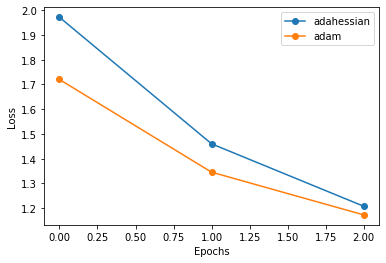

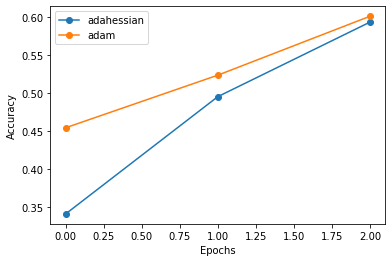

In [11]:
# PLOT
# Read the saved losses and accuracies for each optimizer, plot and save the plot to save_dir
def plot_and_save(optimizers, dataset_name, save_dir, stat_type="Accuracy"):
    plt.figure()
    for optimizer_str in optimizers:
        # Stat list is either a list of loss values or list of accuracies
        stat_list = []
        if stat_type == "Accuracy":
            stat_dir = os.path.join("plots", f"{optimizer_str}_acc.txt")
        else:
            stat_dir = os.path.join("plots", f"{optimizer_str}_loss.txt")
            
        with open(stat_dir, "r") as f:
            for data in f:
                stat_list.append(float(data.strip()))
        
        # Start plotting so all remains on the same figure
        plt.plot(stat_list, '-o', label=optimizer_str)
    
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(stat_type)
    #plt.show()
    plt.savefig(os.path.join(save_dir, "%s_%s_plot.jpg" % (dataset_name, stat_type.lower())))

# Plot and save loss plot
# Change dataset_name as you see appropriate, it's mainly for saving the result

plot_and_save(optimizers, dataset_names[0], "plots", stat_type="Loss")

# Plot and save acc plot
plot_and_save(optimizers, dataset_names[0], "plots", stat_type="Accuracy")